In [1]:
%load_ext autoreload
%autoreload 2 
#default_exp model

In [ ]:
#exporti
from fastai.tabular.all import * 
from tabnet.model import TabNet

# Adult 

In [11]:
adult_path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [12]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)


In [13]:
dls = to.dataloaders(bs=1024)


In [14]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

In [15]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=2.75422871709452e-06)

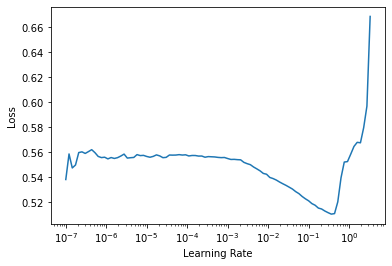

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(150, 1e-1/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.526800,0.619308,0.765510,00:01
1,0.497931,0.534644,0.778716,00:01
2,0.469957,0.426623,0.804668,00:01
3,0.451072,0.417946,0.808968,00:01
4,0.440412,0.422044,0.799140,00:01
5,0.431899,0.417462,0.804975,00:01
6,0.426191,0.407501,0.810197,00:01
7,0.417949,0.397618,0.818796,00:01
8,0.411620,0.402677,0.800061,00:01
9,0.407565,0.396929,0.815878,00:01


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-994453a49d62>", line 1, in <module>
    learn.fit_one_cycle(150, 1e-1/2)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/logargs.py", line 56, in _f
    return inst if to_return else f(*args, **kwargs)
  File "/home/jupyter/libraries/fastai/fastai/callback/schedule.py", line 113, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/logargs.py", line 56, in _f
    return inst if to_return else f(*args, **kwargs)
  File "/home/jupyter/libraries/fastai/fastai/learner.py", line 207, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/home/jupyter/libraries/fastai/fastai/learner.py", line 155, in _with_events
    try: 

TypeError: object of type 'NoneType' has no len()

# Forest Cover DS

In [ ]:
data_dir = Path('./data')

In [ ]:
def extract_gzip(file, dest=None):
    import gzip
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [ ]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [ ]:
target = "Covertype"

cat_names = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

cont_names = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    cont_names + cat_names + [target])

In [ ]:
df = pd.read_csv(forest_path, header=None, names=feature_columns); df.head()
df = df_shrink(df)

In [ ]:
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(0.05)(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names=target, y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders(bs=64*64*4)

In [ ]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(120)

# Poker Hand DS

In [18]:
BASE_DIR = Path.home().joinpath('data/tabnet/poker')

In [19]:
df = pd.read_csv(BASE_DIR.joinpath('train.csv'))
df.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,4,9,2,1,2,2,4,7,2,8,0
1,1,4,3,6,1,12,3,11,2,7,0
2,1,11,4,1,3,7,4,11,2,1,2
3,2,9,2,4,3,6,1,9,4,9,3
4,1,8,2,4,2,11,2,2,2,1,0


In [20]:
cat_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'C1', 'C2', 'C3', 'C4', 'C5']
cont_names = []
target = ['hand']

In [21]:
procs = [Categorify, Normalize]
splits = RandomSplitter(0.05)(range_of(df))

In [22]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names=target, y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders(bs=64*4)

In [23]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

In [24]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [25]:
learn.fit_one_cycle(1000)

epoch,train_loss,valid_loss,accuracy,time
0,1.209984,1.080930,0.487200,00:03
1,1.060052,1.027803,0.495200,00:03
2,1.017989,1.007156,0.480000,00:03
3,1.003484,0.992908,0.496800,00:04
4,0.996357,0.997224,0.508800,00:04
5,0.998841,0.994595,0.495200,00:04
6,0.996585,1.001700,0.484800,00:04
7,0.992384,0.988163,0.482400,00:04
8,0.988533,0.990511,0.502400,00:03
9,0.989381,0.993684,0.492800,00:03



KeyboardInterrupt



# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()